# Tutorial 6 (b)
# Seasonal ARIMA (SARIMA)

We implement the SARIMA (Seasonal Autoregressive Integrated Moving Average) model to forecast seasonal data using python. This data captures the monthly net electricity generation from coal in the country provided by the U.S. Energy Information Administration. The numbers are in Kilowatthours. 

### Can we forecast values using SARIMA model for 2030?

Import the libraries

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### A seasonal ARIMA model or SARIMA is written as follows:

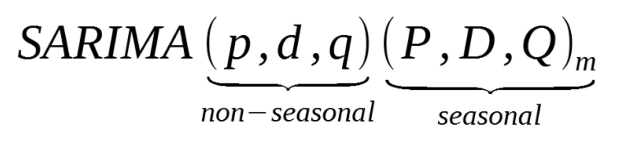

In [4]:
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline
img = mpimg.imread('Image_6.png')
plt.figure(figsize=(8,12))
plt.axis('off')
plt.imshow(img);

We can see that we add P, D, and Q for the seasonal portion of the time series. They are the same terms as the non-seasonal components, by they involve backshifts of the seasonal period.

In the formula above, m is the number of observations per year or the period. If we are analyzing quarterly data, m would equal 4.

## ACF and PACF plots

The seasonal part of an AR and MA model can be inferred from the PACF and ACF plots. In the case of a SARIMA model with only a seasonal moving average process of order 1 and period of 12, denoted as:

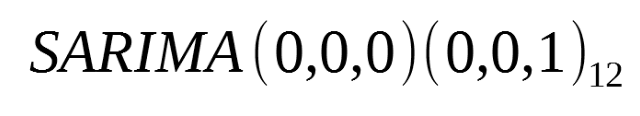

In [5]:
import matplotlib.image as mpimg
%matplotlib inline
img=mpimg.imread('Image_7.png')
plt.figure(figsize=(8,12))
plt.axis('off')
plt.imshow(img);

1. A spike is observed at lag 12
2. Exponential decay in the seasonal lags of the PACF (lag 12, 24, 36, …)

Similarly, for a model with only a seasonal autoregressive process of order 1 and period of 12:

## Modelling
The modelling process is the same as with non-seasonal ARIMA models. In this case, we simply need to consider the additional parameters.

Steps required to make the time series stationary and selecting the model according to the lowest AIC remain in the modelling process.

Let’s cover a complete example with a real-world dataset.

## Loading Data

In the first step, we will load the dataset using pandas and check the first five elements of the datasheet i.e. head of the dataset.

In [7]:
# Import data from EIA - Weekly Natural Gas Storage Report
data = pd.read_csv('Electricity_Net_Generation_From_Coal_Electric_Power_Sector_Monthly.csv')

# Display the records
data.head(12)

,Date,Electricity
0,Jan-73,75190.149
1,Feb-73,67797.946
2,Mar-73,67387.612
3,Apr-73,63935.049
4,May-73,64927.181
5,Jun-73,69592.039
6,Jul-73,75988.308
7,Aug-73,78365.191
8,Sep-73,71304.493
9,Oct-73,70104.344


## Visualizing Dataset

Let's visualize the electricity net generation between 1973 and 2021. The code for producing this visualization is as follows:

<Figure size 1200x500 with 0 Axes>

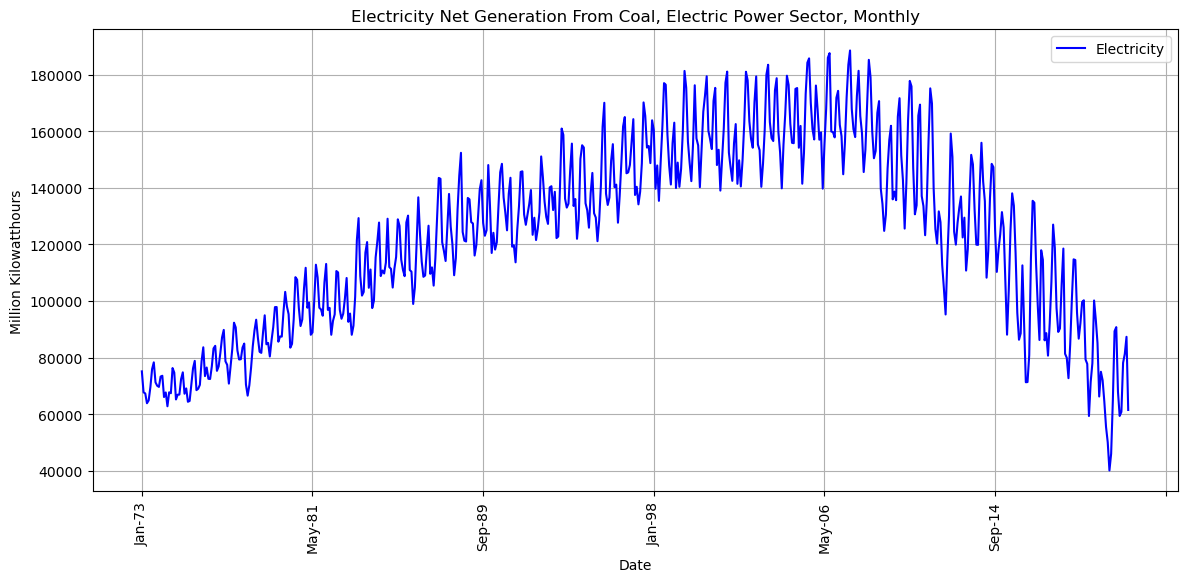

In [9]:
# Visualize net electricity generation from coal since 1973
plt.figure(figsize=[12, 5]); # Set dimensions for figure
data.plot(x = 'Date', y = 'Electricity', figsize = (14, 6), color = 'b')   # 
plt.title('Electricity Net Generation From Coal, Electric Power Sector, Monthly')
plt.ylabel('Million Kilowatthours')
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.grid(True)
plt.show();

## Testing the Stationarity of the Dataset

***Let us use the Augmented Dickey-Fuller Test, a well known statistical test that can help determine if the time series is stationary.*** The ADF test is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if the unit root is present. The Null Hypothesis states there is the presence of a unit root. If the p-value is less than the Significance Level defined, we reject the Null Hypothesis that the time series contains a unit root. In other words, by rejecting the Null hypothesis, we can conclude that the time series is stationary.

In [10]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey-Fuller test (ADF Test)
ad_fuller_result = adfuller(data['Electricity'])

# Display the outcome of Augmented Dicky-Fuller Test
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.142878878148083
p-value: 0.6976730759149165


## Differencing

Since the p-value is large, we cannot reject the null hypothesis and must assume that the time series is non-stationary. We commit to the first order differencing of electricity values and perform ADF test again on the dataset.

In [11]:
data['Electricity First Difference'] = data['Electricity'] - data['Electricity'].shift(1)
# Shift index by desired number of periods with an optional time `freq`.

# Show first five records
data.head()

,Date,Electricity,Electricity First Difference
0,Jan-73,75190.149,NaN
1,Feb-73,67797.946,-7392.203
2,Mar-73,67387.612,-410.334
3,Apr-73,63935.049,-3452.563
4,May-73,64927.181,992.132


In [12]:
# Drop NA values
data.dropna(subset = ["Electricity First Difference"], inplace = True)

# Show first five records
data.head()

,Date,Electricity,Electricity First Difference
1,Feb-73,67797.946,-7392.203
2,Mar-73,67387.612,-410.334
3,Apr-73,63935.049,-3452.563
4,May-73,64927.181,992.132
5,Jun-73,69592.039,4664.858


In [13]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['Electricity First Difference'])

# Display the outcomes of Dicky Fuller test
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.082264335282727
p-value: 1.0850793453618961e-07


## Differenced Series 

The p-value is now less than 0.05, meaning that we can reject the null hypothesis i.e. the time series is stationary. Next, let us visualize the differenced series.

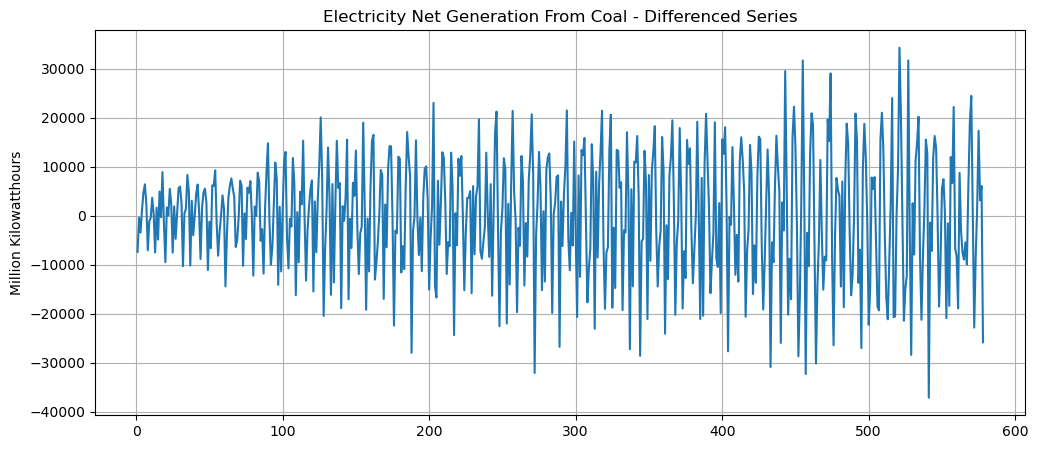

In [14]:
plt.figure(figsize = [12, 5]); # Set dimensions for figure
data['Electricity First Difference'].plot()
plt.title('Electricity Net Generation From Coal - Differenced Series')
plt.ylabel('Million Kilowatthours')
plt.grid(True)

## ACF and PACF Plots

We can use the statsmodels library to build auto-correlation (ACF) and partial auto-correlation plots from the differenced series. ACF describes how well the present value of the series is related with its past values while PACF finds correlation of the residuals with the next lag value.

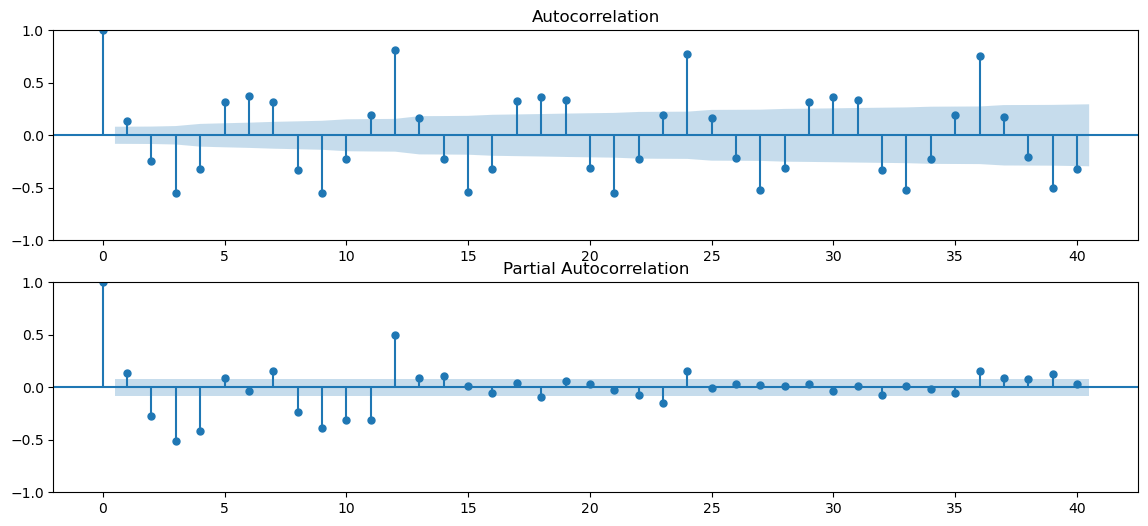

In [15]:
import statsmodels.api as sm
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Electricity First Difference'].dropna(),lags = 40,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Electricity First Difference'].dropna(),lags = 40,ax = ax2)

In [16]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
# A nested loop is written to calculate the AIC values
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = ARIMA(data['Electricity'], order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)

[[0, 1, 0, 12497.767635039883], [0, 1, 1, 12483.685001606607], [0, 1, 2, 12382.881332730345], [1, 1, 0, 12488.963379222554], [1, 1, 1, 12486.648700379916], [1, 1, 2, 12353.923085726092], [2, 1, 0, 12446.855142277374], [2, 1, 1, 12275.979721554102], [2, 1, 2, 12115.926449387687], [0, 2, 0, 12787.185568805187], [0, 2, 1, 12494.453288301629], [0, 2, 2, 12479.21755936713], [1, 2, 0, 12747.271756685648], [1, 2, 1, 12481.407990064716], [1, 2, 2, 12480.371086819508], [2, 2, 0, 12737.592440520219], [2, 2, 1, 12471.77872001544], [2, 2, 2, 12481.381700488231]]


## SARIMA Model

After determining that our time series is stationary, we can use the SARIMA model to predict future values. The model's notation is SARIMA(p, d, q) (P, D, Q)lag. These three parameters account for seasonality, trend, and noise in data. We will use the AIC (Akaike information criterion) indicator which is an estimator of the relative quality of statistical models. The lower the AIC value the better. After performing multiple iterations, the model suggests that SARIMAX(2, 1, 2)x(2, 1, 2, 12) with AIC value of 11413 is the best combination.

In [17]:
# order = (2, 1, 2) means 
# First 2 for auto regressive model, 1 for difference, and second 2 for moving average
# seasonal_order = (2, 1, 2, 12) means
# 12 additional parameter means number of observations per year or the period
best_model = SARIMAX(data['Electricity'], order = (2, 1, 2), seasonal_order = (2, 1, 2, 12)).fit(dis = -1)

# Display the summary of the model
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Electricity   No. Observations:                  578
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -5697.590
Date:                            Tue, 02 Apr 2024   AIC                          11413.179
Time:                                    17:01:50   BIC                          11452.211
Sample:                                         0   HQIC                         11428.414
                                            - 578                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4891      1.990      0.246      0.806      -3.411       4.389
ar.L2         -0.1146      0.735   

After we have fitted the model to the data, we check the residual plots to verify the validity of the model fit. A good forecasting method will have minimal information left in the residuals if any.

## Diagnostic plotting 

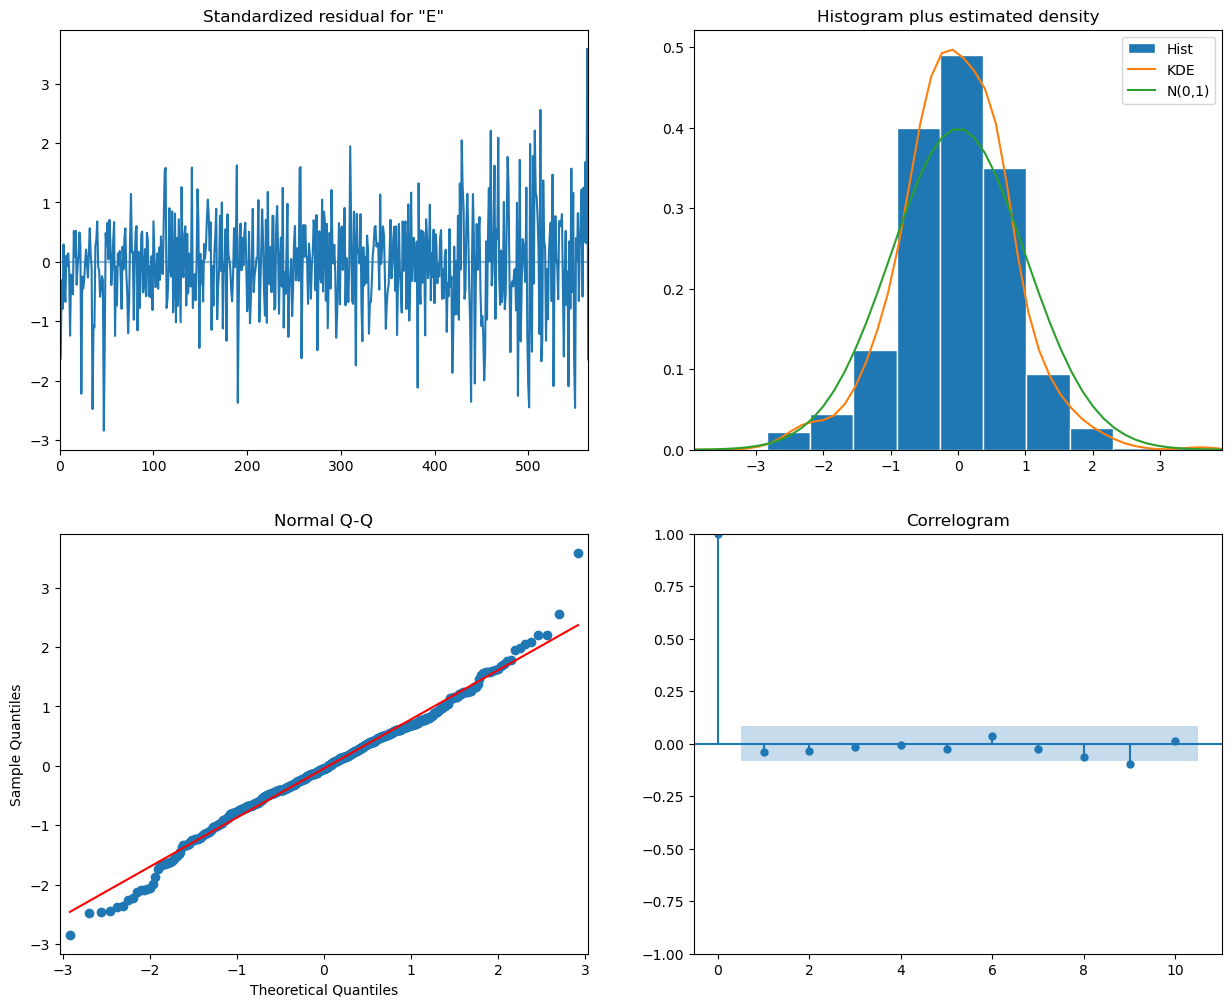

In [18]:
# Diagnosing the model residuals
best_model.plot_diagnostics(figsize = (15, 12))
plt.show()

The correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise. Therefore, these residuals are uncorrelated and have close to zero mean.

## Model Forecast

In the forecast step, we will try to predict the electricity generation data for the next 160 steps or 10 years. The graph below shows a good fit compared to historical data.

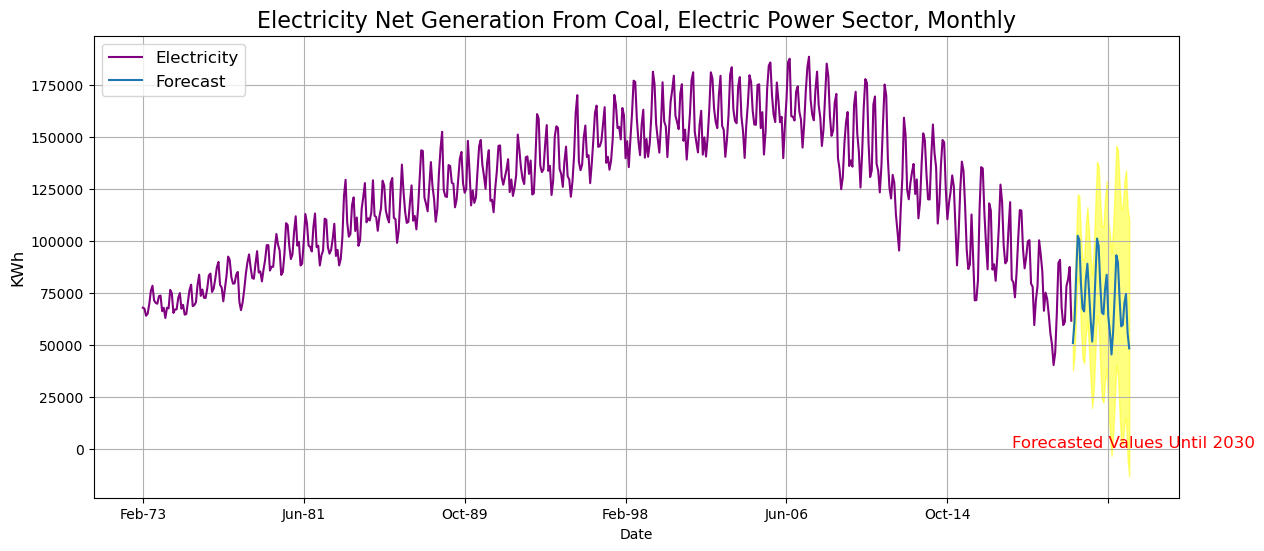

In [23]:
# Forecasting 3 years steps ahead
forecast_values = best_model.get_forecast(steps = 36)

# Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

# Plot the data
ax = data.plot(x = 'Date', y = 'Electricity', figsize = (14, 6), legend = True, color = 'purple')

# Plot the forecasted values 
forecast_values.predicted_mean.plot(ax = ax, label = 'Forecast', figsize = (14, 6), grid = True)

# Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color = 'yellow', alpha = .5)
plt.title('Electricity Net Generation From Coal, Electric Power Sector, Monthly', size = 16)
plt.ylabel('KWh', size = 12)
plt.legend(loc = 'upper left', prop = {'size': 12})
ax.axes.get_xaxis().set_visible(True)
# annotation
ax.text(540, 400, 'Forecasted Values Until 2030', fontsize = 12,  color = 'red')
plt.show()

##  Validating the Forecast

To evaluate the model performance, we calculate the R-squared score and the root mean square error of my dataset to test the authenticity of the model. 

R Squared gives an indication of how well a model fits a given dataset. It indicates how close the regression line (i.e the predicted values plotted) is to the actual data values. The R squared value lies between 0 and 1 where 0 indicates that this model doesn't fit the given data and 1 indicates that the model fits perfectly to the dataset provided. 

Root Mean Squared Error (RMSE) is the distance, on average, of a data point from the fitted line, measured along a vertical line.


In [24]:
# Divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train = data[:int(0.85 * (len(data)))]
test  = data[int(0.85 * (len(data))):]

train.shape, test.shape

((491, 3), (87, 3))

In [25]:
train.head()

,Date,Electricity,Electricity First Difference
1,Feb-73,67797.946,-7392.203
2,Mar-73,67387.612,-410.334
3,Apr-73,63935.049,-3452.563
4,May-73,64927.181,992.132
5,Jun-73,69592.039,4664.858


In [26]:
start = len(train)
end   = len(train) + len(test) - 1
predictions = best_model.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('SARIMA Predictions')
print(predictions)

492    144018.064957
493    133507.384474
494    137150.966707
495    118514.633872
496    120473.123322
           ...      
574     58620.316633
575     66895.184579
576     79231.004961
577     63241.674713
578     72617.234949
Name: SARIMA Predictions, Length: 87, dtype: float64


In [27]:
# Create a dataframe to store r2 score
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Electricity'], predictions)}, index = [0])

# Add columns in the dataframe 'evaluation_results'
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Electricity'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Electricity'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['Electricity'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Electricity'])
                                                               /np.abs(test['Electricity']))*100 
# Display the results
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.900273,6405.520731,6.490222e+07,8056.191141,7.087797


## Conclusion

The model showed 90.0% accuracy as R2 score is 0.90. The RMSE value of 8056 is directly interpretable in terms of Kilowatthours and is not too high. 

## Reference:
- <p>https://medium.com/mlearning-ai/how-to-build-sarima-model-in-python-7ae83b14c884</p>